In [1]:
clean_up = True # if True, remove all gams related files from working folder before starting
%run stdPackages.ipynb
os.chdir(main)
%run stdPlotting.ipynb
os.chdir(d['py'])
from mCGE import NCP_CGE as CGE
from mEmissions import EmRegTargetsFromSYT, EmRegTargetsFromSYT_xt0

The file _gams_py_gdb0.gdx is still active and was not deleted.
The file _gams_py_gdb1.gdx is still active and was not deleted.
The file _gams_py_gdb10.gdx is still active and was not deleted.
The file _gams_py_gdb11.gdx is still active and was not deleted.
The file _gams_py_gdb12.gdx is still active and was not deleted.
The file _gams_py_gdb13.gdx is still active and was not deleted.
The file _gams_py_gdb14.gdx is still active and was not deleted.
The file _gams_py_gdb15.gdx is still active and was not deleted.
The file _gams_py_gdb16.gdx is still active and was not deleted.
The file _gams_py_gdb17.gdx is still active and was not deleted.
The file _gams_py_gdb18.gdx is still active and was not deleted.
The file _gams_py_gdb2.gdx is still active and was not deleted.
The file _gams_py_gdb3.gdx is still active and was not deleted.
The file _gams_py_gdb4.gdx is still active and was not deleted.
The file _gams_py_gdb5.gdx is still active and was not deleted.
The file _gams_py_gdb6.gdx is s

# Emission regulation

In [2]:
vName, t0 = 'vSimpleEOP_SAC', 2019
name = '_'.join([vName, str(t0), 'CGE','calibration'])
M = CGE.load(os.path.join(d['data'], name))
db = M.db.copy() # baseline
dbs  = {}

## 1. Define optimal regulation absent emission targets

Allow the model to define optimal output taxes:

In [3]:
# instruments = ('or', [M.g('output', m = 'P'), M.g('L', m = 'HH')]) 
instruments = M.g('output', m = 'P')
fullCondition = ('and', [instruments, M.g('tx2E')])
M.m['W'].endogenousPol = [('tauS', fullCondition)] 
M.m['W'].initStuff() # re-initialize groups
M.opt, M.m['W'].active = True, True

Solve for optimal taxes:

In [4]:
dbs['opt'] = M.solve(state = 'B')

Update database:

In [5]:
MergeDbs.merge(M.db, dbs['opt'])

Recalculate linear reduction paths based on this new baseline:

In [6]:
targets = pd.Series([0], index = pd.Index([2050], name = 't'))
[M.db.aom(v, name = k) for k,v in EmRegTargetsFromSYT_xt0(targets, db('t'), M.db('qCO2agg').xs(t0+1)).items()];

## 2. Implement regulation

In [7]:
tPlot = pd.Index(range(t0+1, 2060), name = 't')

### 2.1. SYT

In [8]:
M.updateRegulation('SYT')
M.m['M'].initStuff() # re-initialize group definitions etc.
M.opt, M.m['W'].active = False, False # no longer use optimization approach
M.m['W'].initStuff() # re-define groups
M.db.mergeInternal()
dbs[M.regulation] = M.jSolve(100, state = 'B', ϕ = .5)

Check out capital formation:

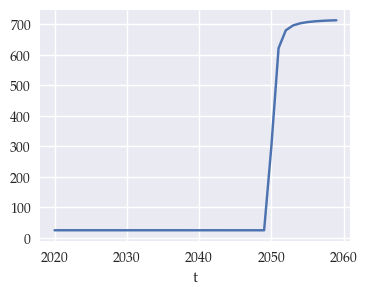

In [9]:
adj.rc_pd(dbs['SYT']('qK_EOP'), tPlot).plot(figsize=(4,3));

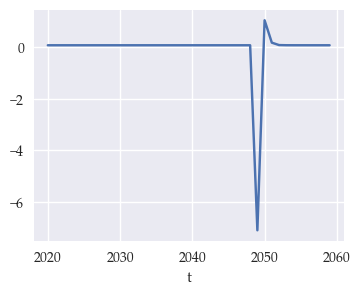

In [10]:
adj.rc_pd(dbs['SYT']('pK_EOP'), tPlot).plot(figsize=(4,3));

### 2.2. SYT with HR

In [11]:
M.updateRegulation('SYT_HR')
M.m['M'].initStuff() # re-initialize group definitions etc.
M.db.mergeInternal()
dbs[M.regulation] = M.jSolve(25, state = 'B', ϕ = 1)

Add this solution as the new initial levels in the main database:

In [12]:
[M.db.__setitem__(k, dbs[M.regulation][k]) for k in M.db.getTypes(['var']) if k in dbs[M.regulation].symbols]; # use solution database

Check path out:

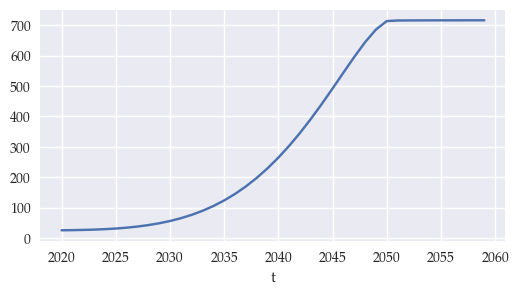

In [13]:
adj.rc_pd(dbs[M.regulation]('qK_EOP'), tPlot).plot(figsize=(6,3));

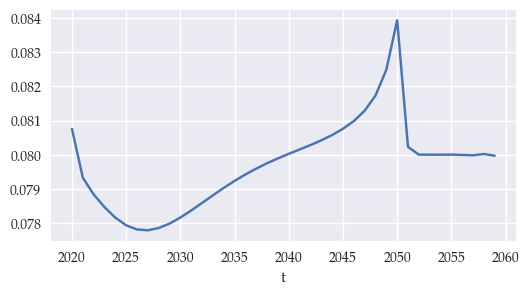

In [14]:
adj.rc_pd(dbs[M.regulation]('pK_EOP'), tPlot).plot(figsize=(6,3));

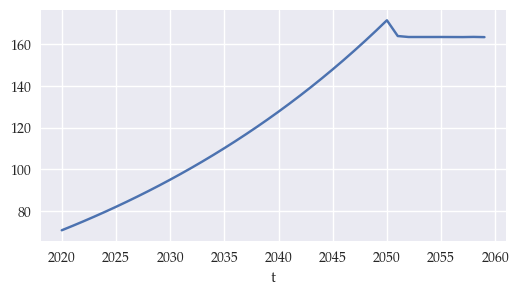

In [15]:
adj.rc_pd(dbs[M.regulation]('tauCO2agg'), tPlot).plot(figsize=(6,3));

### 2.3. SYT_OPT regulation

*Try to start the database from the 'SYT' regulation:*

In [16]:
[M.db.__setitem__(k, dbs['SYT'][k]) for k in M.db.getTypes(['var']) if k in dbs['SYT'].symbols]; # use solution database

*Single year targets with policy that maximizes consumer welfare:*

In [17]:
M.updateRegulation('SYT_OPT')
M.m['M'].initStuff() # re-initialize group definition etc.
dbs[M.regulation] = M.solve(state = 'B')

Check it out:

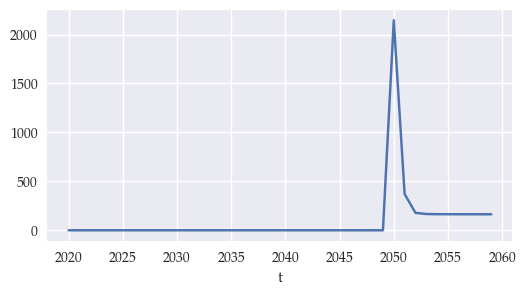

In [18]:
adj.rc_pd(dbs[M.regulation]('tauCO2agg'), tPlot).plot(figsize=(6,3));

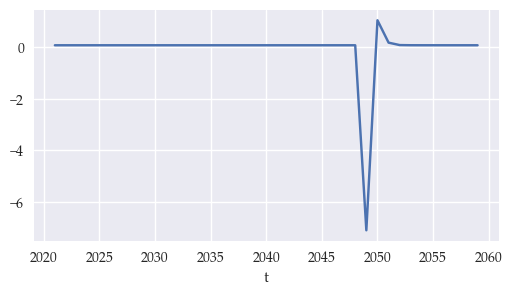

In [19]:
adj.rc_pd(dbs[M.regulation]('pK_EOP'), tPlot).iloc[1:].plot(figsize=(6,3));

### 2.4. LRP

*Start this from hotelling-like rule:*

In [20]:
[M.db.__setitem__(k, dbs['SYT_HR'][k]) for k in M.db.getTypes(['var']) if k in dbs['SYT_HR'].symbols]; # use solution database

*Solve:*

In [21]:
M.updateRegulation('LRP')
M.opt, M.m['W'].active = False, False 
M.m['M'].initStuff() # re-initialize group definition etc.
dbs[M.regulation] = M.solve(state = 'B')

Check it out:

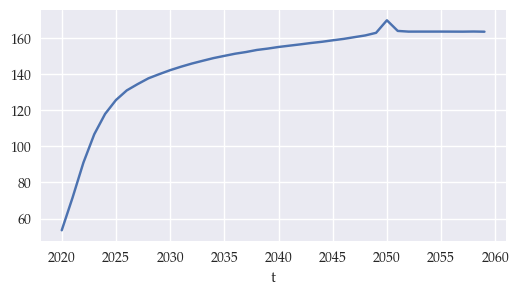

In [22]:
adj.rc_pd(dbs['LRP']('tauCO2agg'), tPlot).plot(figsize=(6,3));

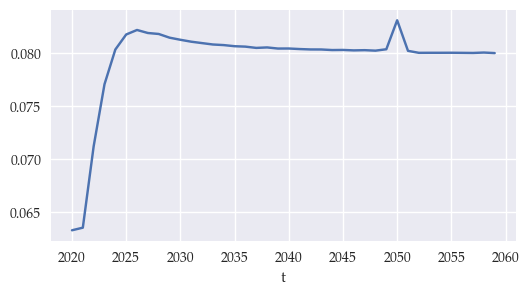

In [23]:
adj.rc_pd(dbs['LRP']('pK_EOP'), tPlot).plot(figsize=(6,3));

### 2.5. Cumulative emission budget 

In [24]:
M.updateRegulation('EB_HR')
M.opt, M.m['W'].active = False, False 
M.m['M'].initStuff() # re-initialize group definitions etc.
dbs[M.regulation] = M.solve(state = 'B')

*Cumulative emission budget policy that maximizes consumer welfare:*

In [25]:
MergeDbs.merge(M.db, dbs['EB_HR']) # use EB_HR as the new initial point 
M.updateRegulation('EB_OPT')
M.m['M'].initStuff() # re-initialize group definitions etc.
dbs[M.regulation] = M.solve(state = 'B')

Check it out:

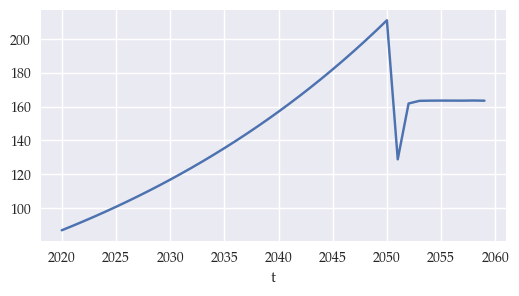

In [26]:
adj.rc_pd(dbs['EB_HR']('tauCO2agg'), tPlot).plot(figsize=(6,3));

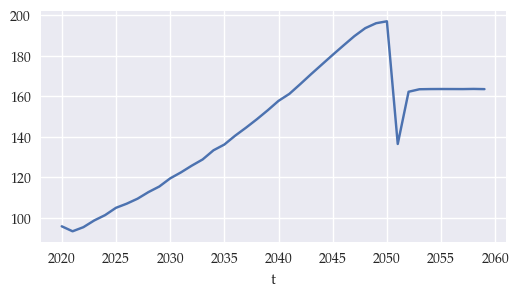

In [27]:
adj.rc_pd(dbs['EB_OPT']('tauCO2agg'), tPlot).plot(figsize=(6,3));

### 2.6. Redo the LRP, EB_HR, and EB_OPT with emission budget from SYT regulation

In [28]:
dbsWithSYT = dict.fromkeys(['LRP','EB_HR','EB_OPT'])

Revert database back to baseline:

In [29]:
MergeDbs.merge(M.db, dbs['opt']) # revert database to this 

Update target for cumulative emission budget:

In [30]:
Q̄ = dbs['SYT_OPT']('qCO2agg').loc[t0+1:2050].sum()
M.db['qCO2_EB'] = pd.Series(Q̄, index = db('qCO2_EB').index)

Update linear reduction path by computing $\Delta$ in the following:
$$
\begin{align}
    \sum_{s=1}^T \left(Q_t-s\Delta\right) = \overline{Q},
\end{align}
$$
where $\overline{Q}$ is the sum of emissions with SYT_OPT regulation. This comes down to
$$
\begin{align}
    \Delta = \dfrac{T Q_t-\overline{Q}}{\sum_{s=1}^T s} = \dfrac{T Q_t-\overline{Q}}{(T+1)T/2}
\end{align}
$$

In [31]:
Δ = ((2050-t0)*dbs['opt']('qCO2agg').xs(t0+1)-Q̄)/((2050-t0+1)*(2050-t0)/2)
M.db.aom(pd.Series(dbs['opt']('qCO2agg').xs(t0+1)-Δ * range(1, 2050-t0+1), index = pd.Index(range(t0+1,2050+1), name = 't')), 
         name = 'qCO2_LRP')

Solve again (start from scratch):

In [32]:
M.updateRegulation('LRP')
M.opt, M.m['W'].active = False, False 
M.m['M'].initStuff() # re-initialize group definition etc.
dbsWithSYT[M.regulation] = M.jSolve(50, state = 'B')

Use LRP as starting point and redo with EB_HR:

In [33]:
[M.db.__setitem__(k, dbsWithSYT['LRP'][k]) for k in M.db.getTypes(['var']) if k in dbsWithSYT['LRP'].symbols]; # use solution database
M.updateRegulation('EB_HR')
M.opt, M.m['W'].active = False, False 
M.m['M'].initStuff() # re-initialize group definitions etc.
dbsWithSYT[M.regulation] = M.solve(state = 'B')

*Cumulative emission budget policy that maximizes consumer welfare:*

In [34]:
MergeDbs.merge(M.db, dbsWithSYT['EB_HR']) # use EB_HR as the new initial point 
M.updateRegulation('EB_OPT')
M.m['M'].initStuff() # re-initialize group definitions etc.
dbsWithSYT[M.regulation] = M.solve(state = 'B')

### 2.7. Calculate EV measures for each case:

Reset to baseline database and settings. Active EV module, set DeltaWelfare = 0 and solve EV for each regulation type:

In [35]:
MergeDbs.merge(M.db, dbs['opt'])
evs = dict.fromkeys(['SYT','SYT_HR','SYT_OPT','LRP','EB_HR','EB_OPT'])
evs_syt_target = dict.fromkeys(['LRP','EB_HR','EB_OPT'])
M.updateRegulation(None)
M.m['M'].initStuff()
M.opt, M.m['W'].active = False, False 
M.m['EV'].active = True
M.db['DeltaWelfare'] = 0
for reg in evs:
    M.db['OptWelObj0'] = dbs[reg]('OptWelObj')
    M.db.mergeInternal()
    evs[reg] = M.solve(state='B')
for reg in evs_syt_target:
    M.db['OptWelObj0'] = dbsWithSYT[reg]('OptWelObj')
    M.db.mergeInternal()
    evs_syt_target[reg] = M.solve(state='B')    

## 3. Plots

Plot CO2 taxes for the different types (keep the same scale for all subplots):

In [36]:
tau2DKK = db._scale/(db('M1990') * 1e6)

Plot tax rates over time for SYT (optimal) and SYT with hotelling rule:

In [37]:
df_tau_SYT = pd.concat([dbs['SYT_HR']('tauCO2agg').rename('Hotelling Rule (SYT)'), dbs['SYT_OPT']('tauCO2agg').rename('Optimal (SYT)')], axis = 1) * tau2DKK
df_tau_EB = pd.concat([dbs['EB_HR']('tauCO2agg').rename('Hotelling Rule (EB)'), dbs['EB_OPT']('tauCO2agg').rename('Optimal (EB)'), dbs['LRP']('tauCO2agg').rename('LRP')], axis = 1) * tau2DKK

Compare taxes:

In [38]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
seaborn.lineplot(data = adj.rc_pd(df_tau_SYT, tPlot), ax = ax, linewidth = 3, legend = True);
ax.set_ylabel('DKK/ton CO2');
ax.set_xlabel('');
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_SYT_tau.pdf"),edgecolor='k')

In [39]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
seaborn.lineplot(data = adj.rc_pd(df_tau_EB, tPlot), ax = ax, linewidth = 3, legend = True);
ax.set_ylabel('DKK/ton CO2');
ax.set_xlabel('');
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_EB_tau.pdf"),edgecolor='k')

Plot emissions over time:

In [40]:
df_qCO2_SYT = pd.concat([dbs['SYT_HR']('qCO2agg').rename('Hotelling Rule (SYT)'), 
                         dbs['SYT_OPT']('qCO2agg').rename('Optimal (SYT)')], axis = 1)
df_qCO2_EB = pd.concat([dbs['EB_HR']('qCO2agg').rename('Hotelling Rule (EB)'),
                        dbs['EB_OPT']('qCO2agg').rename('Optimal (EB)'), 
                        dbs['LRP']('qCO2agg').rename('LRP')], axis = 1)

Compare CO2 emissions:

In [41]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
seaborn.lineplot(data = adj.rc_pd(df_qCO2_SYT, tPlot), ax = ax, linewidth = 3, legend = True);
ax.set_ylabel('CO2 relative to 1990 level');
ax.set_xlabel('');
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_SYT_qCO2.pdf"),edgecolor='k')

In [42]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
seaborn.lineplot(data = adj.rc_pd(df_qCO2_EB, tPlot), ax = ax, linewidth = 3, legend = True);
ax.set_ylabel('CO2 relative to 1990 level');
ax.set_xlabel('');
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_EB_qCO2.pdf"),edgecolor='k')

Plot household consumption over time:

In [43]:
df_Cons_SYT = pd.concat([dbs['SYT_HR']('qD').xs(('HH','C_HH'), level = ['s','n']).rename('Hotelling Rule (SYT)'), 
                         dbs['SYT_OPT']('qD').xs(('HH','C_HH'), level = ['s','n']).rename('Optimal (SYT)'),
                         dbs['opt']('qD').xs(('HH','C_HH'), level = ['s','n']).rename('Baseline (no climate policy)')], axis = 1)

In [44]:
df_Cons_EB = pd.concat([dbs['EB_HR']('qD').xs(('HH','C_HH'), level = ['s','n']).rename('Hotelling Rule (EB)'), 
                         dbs['EB_OPT']('qD').xs(('HH','C_HH'), level = ['s','n']).rename('Optimal (EB)'),
                         dbs['LRP']('qD').xs(('HH','C_HH'), level = ['s','n']).rename('LRP')], axis = 1)

Compare:

In [45]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
seaborn.lineplot(data = adj.rc_pd(df_Cons_SYT, tPlot), ax = ax, linewidth = 3, legend = True);
ax.set_ylabel('Consumption (bio. DKK)', labelpad = 5);
ax.set_xlabel('');
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_SYT_Cons.pdf"),edgecolor='k')

In [46]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
seaborn.lineplot(data = adj.rc_pd(df_Cons_EB, tPlot), ax = ax, linewidth = 3, legend = True);
ax.set_ylabel('Consumption (bio. DKK)', labelpad = 5);
ax.set_xlabel('');
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_EB_Cons.pdf"),edgecolor='k')

## 3.2. Compare EV measures:

Compare EVs across all regulation types:

In [47]:
regNames = {'SYT_OPT': 'Optimal (SYT)',
         'SYT_HR': 'Hotelling Rule (SYT)',
         'EB_OPT': 'Optimal (EB)',
         'EB_HR': 'Hotelling Rule (EB)',
         'LRP': 'Linear Reduction Path'}

Collect EVs:

In [48]:
EV = pd.Series([evs[reg]('vA_F').xs('HH')/evs[reg]('pD').xs((t0, 'HH','C_HH')) for reg in regNames],
               index = [regName for regName in regNames.values()])

In [49]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
EV.plot.bar(ax = ax);
ax.set_ylabel('EV (bio. DKK)', labelpad = 5);
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_EVs.pdf"),edgecolor='k')

Compare EVs where emission reductions are the same:

In [50]:
EVsameReduction = pd.Series(([evs[reg]('vA_F').xs('HH')/evs[reg]('pD').xs((t0, 'HH','C_HH')) for reg in ('SYT_OPT','SYT_HR')]+
                             [evs_syt_target[reg]('vA_F').xs('HH')/evs_syt_target[reg]('pD').xs((t0,'HH','C_HH')) for reg in ('EB_OPT','EB_HR','LRP')]),
                            index = [regName for regName in regNames.values()])

In [51]:
%%capture
one_graph()
fig, ax = plt.subplots(1,1, figsize = (14,8));
EVsameReduction.plot.bar(ax = ax);
ax.set_ylabel('EV (bio. DKK)', labelpad = 5);
fig.tight_layout();
fig.savefig(os.path.join(d['figs'],f"{vName}_EVs_SameReduction.pdf"),edgecolor='k')

## Export all solutions

In [52]:
[dbi.export(name = f'{vName}_{reg}db', repo = d['data']) for reg, dbi in dbs.items()];
[dbi.export(name = f'{vName}_sameReduction_{reg}db', repo = d['data']) for reg, dbi in dbsWithSYT.items()];
[dbi.export(name = f'{vName}_EV_{reg}db', repo = d['data']) for reg, dbi in evs.items()];
[dbi.export(name = f'{vName}_EV_sameReduction_{reg}db', repo = d['data']) for reg, dbi in evs_syt_target.items()];